# Classification of Sugarcane Diseases based on Images

## Initial Setup

Examining the train data shows that there are six (6) classes in total:

In [1]:
classes = [
    "Banded_Chlorosis",
    "Brown_Rust",
    "Brown_Spot",
    "Viral",
    "Yellow_Leaf",
    "Healthy",
]

To make it easier to handle the image data, a Python class called `Classification` is defined and it will use the OpenCV library.

This class will contain the method `load_images` that can be used to load the images, as well as the method `resize_images` for resizing all the images.

Property methods `image_count` and `image_dimensions` also allow us to analyze the loaded images and determine if further preprocessing is needed.

In [2]:
from pathlib import Path
from pprint import pprint

import cv2
import numpy as np


class Classification:
    name: str
    images: list[np.ndarray]

    def __init__(self, name: str):
        self.name = name
        self.images = list()

    @property
    def image_count(self) -> int:
        return len(self.images)

    @property
    def image_dimensions(self) -> dict[tuple[int, int, int], int]:
        dims = {}
        for img in self.images:
            if dims.get(img.shape) is None:
                dims[img.shape] = 1
                continue
            dims[img.shape] += 1
        return dims

    @property
    def image_dimensions_distribution(self) -> dict[tuple[int, int, int], int]:
        distrib = {}
        for key, value in self.image_dimensions.items():
            distrib[key] = value / self.image_count
        return distrib

    def load_images(self, top_folder: str = "train") -> None:
        """
        Empties self.images  then loads images using opencv imread

        Returns the length of image_array

        Raises exception upon error
        """
        try:
            self.images = list()
            path = Path(f"{top_folder}/{self.name}")
            image_paths = [img_path for img_path in path.iterdir() if img_path.is_file()]
            for path in image_paths:
                self.images.append(cv2.imread(str(path)))

        except Exception as e:
            raise e

    def square_images(self, image_size: int = 512, with_padding: bool = True) -> None:
        """
        Resizes all images in self.image_array to the specified image size.

        In the event that the source image is not a square and with_padding is True,
        padding will be added to the smaller side to ensure aspect ratio of 1.0.

        Returns None
        """
        for index, item in enumerate(self.images):
            height, width, _ = self.images[index].shape
            aspect_ratio = height / width

            if not with_padding or aspect_ratio == 1:
                self.images[index] = cv2.resize(item, (image_size, image_size))
                continue

            padding_color = (0, 0, 0)
            if aspect_ratio > 1:
                width_padding = (height - width) // 2
                image = cv2.copyMakeBorder(
                    item,
                    0,
                    0,
                    width_padding,
                    width_padding,
                    cv2.BORDER_CONSTANT,
                    value=padding_color,
                )

            else:
                height_padding = (width - height) // 2
                image = cv2.copyMakeBorder(
                    item,
                    height_padding,
                    height_padding,
                    0,
                    0,
                    cv2.BORDER_CONSTANT,
                    value=padding_color,
                )

            self.images[index] = cv2.resize(image, (image_size, image_size))

    def normalize_images(self) -> None:
        """
        Normalizes the values to be from 0 to 1 instead of 0 to 255.

        Returns None
        """
        for index, item in enumerate(self.images):
            self.images[index] = item / 255.0

    def __repr__(self) -> str:
        return f"{self.name}\n image count: {self.image_count}\n image dimensions: {self.image_dimensions}\n dimension distribution: {self.image_dimensions_distribution}"

## Data Loading and Preprocessing

First, create the instances for each class.

In [3]:
classifications = [Classification(_class) for _class in classes]

Then, for each instance, let us load the images under the path `./train/<class_name>`.

We will also display the number of images as well as the dimensions of all images.

In [4]:
for x in classifications:
    x.load_images()
    pprint(x)

Banded_Chlorosis
 image count: 848
 image dimensions: {(512, 384, 3): 808, (288, 384, 3): 40}
 dimension distribution: {(512, 384, 3): 0.9528301886792453, (288, 384, 3): 0.04716981132075472}
Brown_Rust
 image count: 283
 image dimensions: {(512, 384, 3): 281, (288, 384, 3): 2}
 dimension distribution: {(512, 384, 3): 0.9929328621908127, (288, 384, 3): 0.007067137809187279}
Brown_Spot
 image count: 1550
 image dimensions: {(512, 384, 3): 1481, (288, 384, 3): 69}
 dimension distribution: {(512, 384, 3): 0.9554838709677419, (288, 384, 3): 0.044516129032258066}
Viral
 image count: 598
 image dimensions: {(512, 384, 3): 502, (288, 384, 3): 96}
 dimension distribution: {(512, 384, 3): 0.8394648829431438, (288, 384, 3): 0.1605351170568562}
Yellow_Leaf
 image count: 1074
 image dimensions: {(512, 384, 3): 1005, (288, 384, 3): 69}
 dimension distribution: {(512, 384, 3): 0.9357541899441341, (288, 384, 3): 0.06424581005586592}
Healthy
 image count: 387
 image dimensions: {(256, 192, 3): 1, (512,

Two important pieces of information can be gleaned from the output.

1. It can be seen that the six (6) different classes have an imbalance in image count.

This is a problem because it may introduce excessive bias in our models.
To avoid this problem, when training the models, we must use proper sampling techniques to ensure equal class distribution.

2. The images are rectangular and the dimensions are not homogenous.

Most images have a size of `1024x768` but there are some whose size are `576x768` instead.
To ensure that our model will be able to process these images later, we can pad the images to make them a square, and then we resize it.

Lastly, let us normalize the data so that the values are from 0 to 1 instead of 0 to 255.

In [5]:
# Resize all images to 512x512
IMAGE_SIZE = 128
for x in classifications:
    x.square_images(IMAGE_SIZE, with_padding=True)
    x.normalize_images()
    pprint(x)

Banded_Chlorosis
 image count: 848
 image dimensions: {(128, 128, 3): 848}
 dimension distribution: {(128, 128, 3): 1.0}
Brown_Rust
 image count: 283
 image dimensions: {(128, 128, 3): 283}
 dimension distribution: {(128, 128, 3): 1.0}
Brown_Spot
 image count: 1550
 image dimensions: {(128, 128, 3): 1550}
 dimension distribution: {(128, 128, 3): 1.0}
Viral
 image count: 598
 image dimensions: {(128, 128, 3): 598}
 dimension distribution: {(128, 128, 3): 1.0}
Yellow_Leaf
 image count: 1074
 image dimensions: {(128, 128, 3): 1074}
 dimension distribution: {(128, 128, 3): 1.0}
Healthy
 image count: 387
 image dimensions: {(128, 128, 3): 387}
 dimension distribution: {(128, 128, 3): 1.0}


With the images resized, we must also transform our categorical features into a numeric array.

This can be done using Scikit-learn's LabelBinarizer class.

In [6]:
from sklearn.preprocessing import LabelBinarizer

binarizer = LabelBinarizer()
class_labels: list[np.array] = binarizer.fit_transform(classes)  # type: ignore
label_pairings: dict[str, np.ndarray] = dict(zip(classes, class_labels, strict=False))
# Print output and classes to verify
print("Binarizer classes:")
pprint(binarizer.classes_)
print()
pprint(label_pairings, sort_dicts=False)

Binarizer classes:
array(['Banded_Chlorosis', 'Brown_Rust', 'Brown_Spot', 'Healthy', 'Viral',
       'Yellow_Leaf'], dtype='<U16')

{'Banded_Chlorosis': array([1, 0, 0, 0, 0, 0]),
 'Brown_Rust': array([0, 1, 0, 0, 0, 0]),
 'Brown_Spot': array([0, 0, 1, 0, 0, 0]),
 'Viral': array([0, 0, 0, 0, 1, 0]),
 'Yellow_Leaf': array([0, 0, 0, 0, 0, 1]),
 'Healthy': array([0, 0, 0, 1, 0, 0])}


With our processed images and our transformed class labels, let use generate the arrays which will serve as our input array `X` and label array `Y`.

This can be accomplished by combining the images of our classes and generating the corresponding label array using `label_pairings`.

In [7]:
# Create our array X, the input array
X: np.ndarray = np.vstack(
    [np.array(class_.images) for class_ in classifications]
)  # convert the image list of each class into an array then combine them

# Create our array Y, the label array
Y: np.ndarray = np.vstack(
    [
        [label_pairings[class_.name] for _ in range(class_.image_count)]
        for class_ in classifications
    ],
)  # generate the list of one-hot encoded vectors for each class then combine them

print(f"X.shape: {X.shape}\nY.shape: {Y.shape}")

X.shape: (4740, 128, 128, 3)
Y.shape: (4740, 6)



However, we must not forget that our classes are imbalanced.

It is important that balance this out to avoid overfitting towards the classes with a much larger count.

To balance our classes, we can used the Imbalanced-Learn library and then undersample the Majority class.

In [8]:
from imblearn.under_sampling import RandomUnderSampler

RANDOM_STATE_INT = 1738  # Seed for consistency
sampler = RandomUnderSampler(random_state=RANDOM_STATE_INT, replacement=False)

X_flattened = X.reshape(X.shape[0], -1)  # Flatten X for compatibility with RandomUnderSampler

X_balanced: np.ndarray  # type annotation
Y_balanced: np.ndarray  # type annotation
X_balanced, Y_balanced = sampler.fit_resample(X_flattened, Y)  # type: ignore

X_balanced = X_balanced.reshape(-1, *X.shape[1:])
print(f"X_balanced.shape: {X_balanced.shape}\nY_balanced.shape: {Y_balanced.shape}")

# Count the number of occurences per class
class_distribution: dict[str, int] = {}  #
for label in Y_balanced:
    if class_distribution.get(f"{label}") is None:
        class_distribution[f"{label}"] = 1
        continue
    class_distribution[f"{label}"] += 1

print("\nClass Distribution:")
pprint(class_distribution, sort_dicts=False)

X_balanced.shape: (1698, 128, 128, 3)
Y_balanced.shape: (1698, 6)

Class Distribution:
{'[1 0 0 0 0 0]': 283,
 '[0 1 0 0 0 0]': 283,
 '[0 0 1 0 0 0]': 283,
 '[0 0 0 1 0 0]': 283,
 '[0 0 0 0 1 0]': 283,
 '[0 0 0 0 0 1]': 283}


`X_balanced` and `Y_balanced` represent our data with balanced samples. Printing the class distribution also shows that each class has 282 entries each. This matches the cardinality of our minority class, `Brown_Rust`, as identified by our previous cells

Lastly, for validation purposes of our model, a train-test split will be conducted on our data. 

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X_balanced, Y_balanced, train_size=0.8, random_state=RANDOM_STATE_INT, shuffle=True
)

print(
    f"Shapes\n X_train: {len(X_train)}\n Y_train: {len(Y_train)}\n X_test: {len(X_test)}\n Y_test: {len(Y_test)}"
)

Shapes
 X_train: 1358
 Y_train: 1358
 X_test: 340
 Y_test: 340


To improve our data, we can also apply image augmentation.


In [10]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

## Method 1: Convolution Neural Network (CNN)

The first method for solving this classification problem is through the use of CNN.

We will be using the Keras and TensorFlow libraries.

First, let us setup the environment and model.

In [30]:
import os

import keras

# Set Keras backend to use TensorFlow
os.environ["KERAS_BACKEND"] = "tensorflow"

DROPOUT_RATE = 0.20

cnn_model = keras.models.Sequential(
    [
        keras.layers.InputLayer(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="Same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=96, kernel_size=(3, 3), padding="Same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="Same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=192, kernel_size=(3, 3), padding="Same", activation="relu"),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="Same", activation="relu"),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        # fully connected
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(len(classes), activation="softmax"),
    ]
)

cnn_model.summary()


cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

EPOCHS = 30
BATCH_SIZE = 250

history = cnn_model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    # steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    validation_data=(X_test, Y_test),
)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_549 (Conv2D)             │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_550 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_551 (Conv2D)             │ (None, 32, 32, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_552 (Conv2D)             │ (None, 16, 16, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_553 (Conv2D)             │ (None, 8, 8, 192)      │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_554 (Conv2D)             │ (None, 4, 4, 256)      │       442,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,377,382 (5.25 MB)

 Trainable params: 1,377,382 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.1577 - loss: 1.7977 - val_accuracy: 0.2920 - val_loss: 1.7742
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2918 - loss: 1.7630 - val_accuracy: 0.1534 - val_loss: 1.8200
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1536 - loss: 1.8551 - val_accuracy: 0.1622 - val_loss: 1.7814
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1587 - loss: 1.7800 - val_accuracy: 0.1652 - val_loss: 1.7812
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1803 - loss: 1.7718 - val_accuracy: 0.2684 - val_loss: 1.7479
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2731 - loss: 1.6981 - val_accuracy: 0.3038 - val_loss: 1.5964
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3146 - loss: 1.5945 - val_accuracy: 0.3923 - val_loss: 1.5838
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3822 - loss: 1.5499 - val_accuracy: 0.3510 - val_loss: 1.5392
Epoch 9/30
6/6 ━

Displaying the accuracy and validation loss across epochs.

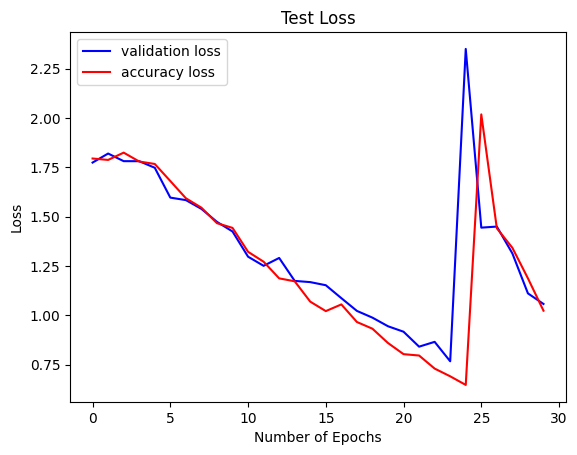

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history["val_loss"], color="b", label="validation loss")
plt.plot(history.history["loss"], color="r", label="accuracy loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Method 2: Transfer Learning from InceptionV3

In [27]:
import keras
from keras.api.applications.inception_v3 import InceptionV3

EPOCHS = 50
BATCH_SIZE = 256

pre_trained_model = InceptionV3(
    input_shape=X_train.shape[1::],
    weights="imagenet",
    include_top=False,  # the fully connected layer at the end
)

for layer in pre_trained_model.layers:
    layer.trainable = False

fully_connected_layer = keras.layers.Flatten()(pre_trained_model.output)
fully_connected_layer = keras.layers.Dense(512, activation="relu")(fully_connected_layer)
fully_connected_layer = keras.layers.Dropout(0.2)(fully_connected_layer)
fully_connected_layer = keras.layers.Dense(len(classes), activation="softmax")(
    fully_connected_layer
)

transfer_model = keras.Model(pre_trained_model.input, fully_connected_layer)

# transfer_model.summary()

transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(), "acc"],
)

history = transfer_model.fit(
    X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, Y_test)
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - acc: 0.2165 - categorical_accuracy: 0.2165 - loss: 16.1926 - val_acc: 0.3529 - val_categorical_accuracy: 0.3529 - val_loss: 10.6704
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - acc: 0.3319 - categorical_accuracy: 0.3319 - loss: 8.0286 - val_acc: 0.3353 - val_categorical_accuracy: 0.3353 - val_loss: 3.7967
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.3829 - categorical_accuracy: 0.3829 - loss: 2.9506 - val_acc: 0.5235 - val_categorical_accuracy: 0.5235 - val_loss: 1.4816
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.5564 - categorical_accuracy: 0.5564 - loss: 1.4521 - val_acc: 0.5559 - val_categorical_accuracy: 0.5559 - val_loss: 1.2630
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - acc: 0.5645 - categorical_accuracy: 0.5645 - loss: 1.2212 - val_acc: 0.6265 - val_categorical_accuracy: 0.6265 - val_loss: 1.0311
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - acc: 0.6548 - categorical_accuracy: 0.6548 - los

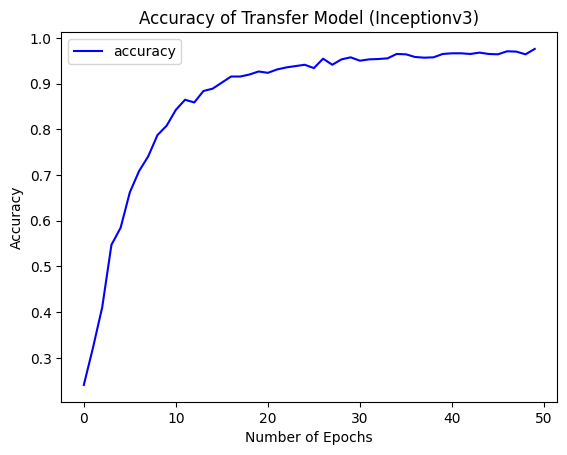

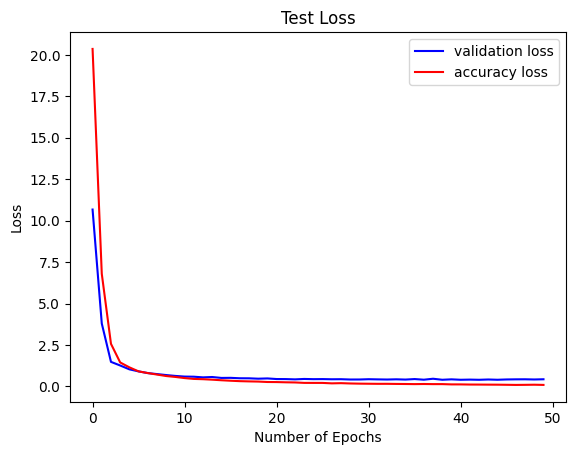

In [ ]:
import matplotlib.pyplot as plt

# show the accuracy of method 2
plt.plot(history.history["acc"], color="b", label="accuracy")
plt.title("Accuracy of Transfer Model (Inceptionv3)")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# show the training (and validation) loss of method 2
plt.plot(history.history["val_loss"], color="b", label="validation loss")
plt.plot(history.history["loss"], color="r", label="accuracy loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
transfer_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_379 (Conv2D) │ (None, 63, 63,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │         96 │ conv2d_379[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_376      │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_380 (Conv2D) │ (None, 61, 61,    │      9,216 │ activation_376[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_380[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_377      │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_381 (Conv2D) │ (None, 61, 61,    │     18,432 │ activation_377[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_381[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_378      │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 30, 30,    │          0 │ activation_378[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_382 (Conv2D) │ (None, 30, 30,    │      5,120 │ max_pooling2d_19… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_382[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_379      │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_383 (Conv2D) │ (None, 28, 28,    │    138,240 │ activation_379[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_383[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_380      │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 34,396,468 (131.21 MB)

 Trainable params: 4,197,894 (16.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 8,395,790 (32.03 MB)